# Building Recommendation System

## Import the Packages

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
from recsysNN_utils import *
from collections import defaultdict
import csv
from numpy import genfromtxt
import pickle
import tabulate
pd.set_option("display.precision", 1)

# Get the dataset

## User Review Dataset

In [2]:
data = pd.read_csv('Data/user_reviews.csv')
data

,productname,rating,user_id,category
0,"herbisida obat pembasmi rumput liar, gulma, al...",5,Bambang,Pestisida & Obat Pertanian
1,"herbisida obat pembasmi rumput liar, gulma, al...",5,Dimas,Pestisida & Obat Pertanian
2,"herbisida obat pembasmi rumput liar, gulma, al...",5,Bambang,Pestisida & Obat Pertanian
3,"herbisida obat pembasmi rumput liar, gulma, al...",5,Rezky,Pestisida & Obat Pertanian
4,"herbisida obat pembasmi rumput liar, gulma, al...",5,Dendy,Pestisida & Obat Pertanian
...,...,...,...,...
147150,Digital Soil Analyzer Tester Meter Alat Ukur p...,5,4qv00hrohw,Teknologi Pertanian
147151,Jaring atap/teduh Paranet shade net 75% list t...,5,4qv00hrohw,Perlengkapan Rumah Kaca dan Pembibitan
147152,"herbisida obat pembasmi rumput liar, gulma, al...",2,4qv00hrohw,Pestisida & Obat Pertanian
147153,Pupuk Cair Daun Super Spray Siap Pakai by BLOO...,3,4qv00hrohw,Pupuk dan Nutrisi Tanaman


## Product Dataset

In [3]:
product_df = pd.read_csv('Data/product.csv')
product_df

,productname,productdescription,rating,sellerid,price,stock,image,category
0,"obat pembasmi pohon dan akar, racun pohon, sta...",Nufarm Starlon Herbisida Sistemik\n\nIsi : 100...,4.9,she-basmi,Rp38.000,96653,9a6345e2-6ae6-4a44-b7cd-042a0a0e6f8b,Pestisida dan Obat tanaman
1,100ml Pestisida Organik Neem Oil /Minyak Mimba...,Takaran 1 sendok utk 1 liter larutan siap paka...,4.9,Panda Farm,Rp25.500,91,58835cb1-a00a-437b-9132-35f538e6bae1,Pestisida dan Obat tanaman
2,Antracol Fungisida-Obat Jamur Tanaman 70WP-250gr,Isi : 250gr\nExp : 01/25\n\nAntracol adalah fu...,4.9,benihkita,Rp49.550,33,3603111_2f32cce9-11e1-4106-8c35-ce50f50f69f3_7...,Pestisida dan Obat tanaman
3,"DESTHIN obat hama tanaman, ulat, kutu putih, h...","kemasan 500ml\n\nsudah menggunakan spray baru,...",4.9,she-basmi,Rp35.000,95969,e6dc4ec2-d4be-4565-b2db-8e51b1624dc2,Pestisida dan Obat tanaman
4,"herbisida obat pembasmi rumput liar, gulma, al...","Kemasan botol 500ml\n\nbotol rusak, bocor, spr...",4.9,she-basmi,Rp35.000,95886,618a27c5-a666-4d96-91b0-29f7d74fcc11,Pestisida dan Obat tanaman
...,...,...,...,...,...,...,...,...
144,ISKU Pressure Sprayer 1L/2L Botol Semprotan Ta...,ãTerima kasih atas kepercayaan dan dukungan ...,4.9,Isku Official Shop,3989000000,4250,id-11134207-7r98q-lvd27q0a7htx37,Alat dan Mesin Pertanian
145,ISKU Semprotan Rumput Sprayer 5L Dan Botol Sem...,ãTerima kasih atas kepercayaan dan dukungan ...,5.0,Isku Official Shop,12499000000,2439,id-11134207-7r98s-lwffeqkx4o3hb9,Alat dan Mesin Pertanian
146,[2PCS] ISKU Alat Semprot Tanaman 5L Dan Botol ...,ãTerima kasih atas kepercayaan dan dukungan ...,4.9,Isku Official Shop,15899000000,2284,id-11134207-7r98y-lwffeqkwdyqy6b,Alat dan Mesin Pertanian
147,ISKU Gunting Rumput Taman Gunting tanaman gunt...,ãTerima kasih atas kepercayaan dan dukungan ...,4.9,Isku Official Shop,9989000000,7909,sg-11134201-23010-4w2r3464n4lv74,Alat dan Mesin Pertanian


# Data Preprocessing

## User Feature Preprocessing

### One hot encode the category column

In [4]:
from sklearn.preprocessing import OneHotEncoder
# one hot encode the category data
Ohe = OneHotEncoder()
category = Ohe.fit_transform(data[['category']])
category = category.toarray()
category = pd.DataFrame(category, columns = Ohe.get_feature_names_out(['category']))
data = pd.concat([data, category], axis=1)
data = data.drop('category', axis=1)
data

,productname,rating,user_id,category_Alat dan Mesin Pertanian,category_Bahan Pengemasan dan Logistik,category_Bibit dan Benih Tanaman,category_Perlengkapan Rumah Kaca dan Pembibitan,category_Pestisida & Obat Pertanian,category_Produk Olahan Pertanian,category_Produk Pertanian Segar,category_Pupuk dan Nutrisi Tanaman,category_Sarana dan Peralatan Irigasi,category_Teknologi Pertanian
0,"herbisida obat pembasmi rumput liar, gulma, al...",5,Bambang,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,"herbisida obat pembasmi rumput liar, gulma, al...",5,Dimas,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,"herbisida obat pembasmi rumput liar, gulma, al...",5,Bambang,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,"herbisida obat pembasmi rumput liar, gulma, al...",5,Rezky,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,"herbisida obat pembasmi rumput liar, gulma, al...",5,Dendy,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147150,Digital Soil Analyzer Tester Meter Alat Ukur p...,5,4qv00hrohw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
147151,Jaring atap/teduh Paranet shade net 75% list t...,5,4qv00hrohw,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
147152,"herbisida obat pembasmi rumput liar, gulma, al...",2,4qv00hrohw,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
147153,Pupuk Cair Daun Super Spray Siap Pakai by BLOO...,3,4qv00hrohw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Make the user feature have user preferences pattern

In [ ]:
# get unique users_id
users_id = data.user_id.unique()
user_profiles = []

for user in users_id:
    user_data = data[data.user_id == user]
    category = user_data.iloc[:, 3:].multiply(user_data['rating'], axis=0)
    category_sum = category.sum(axis=0)
    category_not_zero = category[category != 0]
    category_avg = category_sum / category_not_zero.count()
    category_avg = category_avg.to_frame().T
    rating_count = user_data.shape[0]
    user_new = pd.DataFrame({'user_id': [user], 'rating_count': [rating_count]})
    user_new = pd.concat([user_new, category_avg], axis=1)
    user_new.fillna(0, inplace=True)
    user_profiles.append(user_new)

# Concatenate all user profiles into a single DataFrame
user_profiles_df = pd.concat(user_profiles, ignore_index=True)
user_profiles_df

,user_id,rating_count,category_Alat dan Mesin Pertanian,category_Bahan Pengemasan dan Logistik,category_Bibit dan Benih Tanaman,category_Perlengkapan Rumah Kaca dan Pembibitan,category_Pestisida & Obat Pertanian,category_Produk Olahan Pertanian,category_Produk Pertanian Segar,category_Pupuk dan Nutrisi Tanaman,category_Sarana dan Peralatan Irigasi,category_Teknologi Pertanian
0,Bambang,142,3.2,3.8,4.0,3.7,4.2,3.4,3.4,3.3,3.8,3.8
1,Dimas,57,3.0,3.8,4.0,3.7,4.1,3.0,3.2,3.5,3.3,3.4
2,Rezky,14,3.0,3.5,4.0,3.0,4.5,0.0,2.5,0.0,2.3,0.0
3,Dendy,26,3.0,3.5,4.5,3.4,4.5,4.0,2.5,3.0,2.6,2.0
4,Victor,42,4.0,4.0,4.0,3.2,3.8,3.0,3.6,5.0,3.3,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17507,hAAAAA1,1,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
17508,hfffff1,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17509,hFFFFF1,1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
17510,fredyfredysimeon,9,0.0,3.0,0.0,5.0,2.0,3.0,2.0,3.0,4.0,5.0


### Turn the user_id into categorical

In [12]:
# label encode the user_id
user_data["user_id"] = user_data["user_id"].astype('category')
user_data["user_id"] = user_data["user_id"].cat.codes

### Merge the categorical user_id with user feature

In [7]:
user_data = data[["user_id"]]
user_data = user_data.merge(user_profiles_df, on="user_id", how="left")


## Product Feature Preprocessing

### Turn the product_id into categorical using label encoder

In [8]:
# Transform product into label encode
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
product_data = label_encoder.fit_transform(data['productname'])
product_data = pd.DataFrame(product_data, columns=['product_id'])
product_data = product_data.merge(data, left_index=True, right_index=True)
product_data.drop(["user_id", "productname"], axis=1, inplace=True)
product_data

,product_id,rating,category_Alat dan Mesin Pertanian,category_Bahan Pengemasan dan Logistik,category_Bibit dan Benih Tanaman,category_Perlengkapan Rumah Kaca dan Pembibitan,category_Pestisida & Obat Pertanian,category_Produk Olahan Pertanian,category_Produk Pertanian Segar,category_Pupuk dan Nutrisi Tanaman,category_Sarana dan Peralatan Irigasi,category_Teknologi Pertanian
0,108,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,108,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,108,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,108,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,108,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
147150,27,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
147151,53,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
147152,108,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
147153,88,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Export preprocessed data

In [9]:
# export product_data and user_data
product_data.to_csv('Data/product_data.csv', index=False)
user_data.to_csv('Data/user_data.csv', index=False)

### Load preprocessed data

In [ ]:
# user_data = pd.read_csv('Data/user_data.csv')
# product_data = pd.read_csv('Data/product_data.csv')

### Define user feature, product feature, and target then scale all the data

In [13]:
# scale training data
item_train_unscaled = product_data.drop('rating', axis=1).values
user_train_unscaled = user_data
y_train_unscaled    = product_data['rating'].values

scalerItem = StandardScaler()
scalerItem.fit(product_data.drop('rating', axis=1))
item_train = scalerItem.transform(product_data.drop('rating', axis=1))

scalerUser = StandardScaler()
scalerUser.fit(user_data)
user_train = scalerUser.transform(user_data)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(product_data['rating'].values.reshape(-1, 1))
y_train = scalerTarget.transform(y_train_unscaled.reshape(-1, 1))
#ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train)))
print(np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))

True
True


## Split the data into train set and test set

In [14]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"product/item training data shape: {item_train.shape}")
print(f"product/item test data shape: {item_test.shape}")

product/item training data shape: (117724, 11)
product/item test data shape: (29431, 11)


## Perform ETL 

In [15]:
# make the dataset to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(({"user": user_train, "item": item_train}, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices(({"user": user_test, "item": item_test}, y_test))

# shuffle the data
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
test_dataset = test_dataset.batch(64)

# prefetch the data
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Create Model Architecture

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_user_features = user_train.shape[1]
num_item_features = item_train.shape[1]

# Example item metadata features (e.g., genres, keywords, etc.)
num_outputs = 24
user_NN = tf.keras.Sequential()
item_NN = tf.keras.Sequential()
# Define a function to create a residual block
def residual_block(x, units):
    shortcut = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Dense(units, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units, activation='relu')(x)
    tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, shortcut])
    return x

# User network with residual connections
user_input = tf.keras.layers.Input(shape=(num_user_features,))
x = tf.keras.layers.Dense(1024, activation='relu')(user_input)
x = residual_block(x, 1024)
x = residual_block(x, 512)
x = residual_block(x, 256)
x = residual_block(x, 128)
x = residual_block(x, 64)
user_NN = tf.keras.Model(user_input, x)

# Item network with residual connections
item_input = tf.keras.layers.Input(shape=(num_item_features,))
x = tf.keras.layers.Dense(1024, activation='relu')(item_input)
x = residual_block(x, 1024)
x = residual_block(x, 512)
x = residual_block(x, 256)
x = residual_block(x, 128)
x = residual_block(x, 64)
item_NN = tf.keras.Model(item_input, x)

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features,))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features,))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 11)]                 0         []                            
                                                                                                  
 model (Functional)          (None, 64)                   4913728   ['input_3[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 64)                   4912704   ['input_4[0][0]']             
                                                                                           

## Train the Model

In [17]:
# Example training process
cost_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt,
              loss=cost_fn)

# Train the model
history = model.fit([user_train, item_train], y_train, epochs=100, validation_data=([user_test, item_test], y_test))
model.save('Model/recsysNN_model.h5')

Epoch 1/100

3679/3679 [==============================] - 208s 55ms/step - loss: 0.2329 - val_loss: 0.2014
Epoch 2/100
3679/3679 [==============================] - 207s 56ms/step - loss: 0.1989 - val_loss: 0.1899
Epoch 3/100
3679/3679 [==============================] - 207s 56ms/step - loss: 0.1894 - val_loss: 0.1842
Epoch 4/100
3679/3679 [==============================] - 205s 56ms/step - loss: 0.1834 - val_loss: 0.1810
Epoch 5/100
3679/3679 [==============================] - 205s 56ms/step - loss: 0.1786 - val_loss: 0.1768
Epoch 6/100
3679/3679 [==============================] - 205s 56ms/step - loss: 0.1752 - val_loss: 0.1742
Epoch 7/100
3679/3679 [==============================] - 206s 56ms/step - loss: 0.1721 - val_loss: 0.1723
Epoch 8/100
3679/3679 [==============================] - 205s 56ms/step - loss: 0.1699 - val_loss: 0.1726
Epoch 9/100
3679/3679 [==============================] - 206s 56ms/step - loss: 0.1675 - val_loss: 0.1707
Epoch 10/100
3679/3679 [=====================

c:\Users\salma\miniconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Load the model

In [16]:
model = tf.keras.models.load_model('Model/recsysNN_model.h5')

## Model Evaluation

### Evaluate model with test set

In [18]:
model.evaluate([user_test, item_test], y_test)

920/920 [==============================] - 6s 6ms/step - loss: 0.1496


0.1495719701051712

### Visualize training graph

dict_keys(['loss', 'val_loss'])


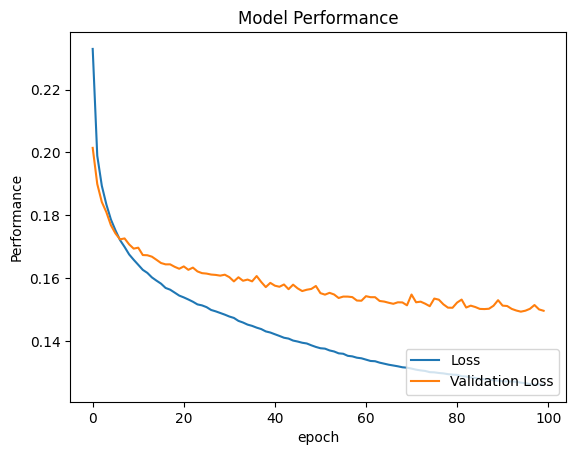

In [27]:
import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Performance')
plt.ylabel('Performance')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation Loss'], loc='lower right')
plt.show()

From the graph, we know that our model is a little bit overfit because we train the model with full 100 epoch, but the gap is still understandable

## Model Testing

### Create new user feature

In [19]:
# create a new dataframe for the user
user_new = pd.DataFrame({'user_id': [19155],
                         'rating_count': [10],
                         'category_Alat dan Mesin Pertanian': [4.8],
                         'category_Bahan Pengemasan dan Logistik': [0.0],
                         'category_Bibit dan Benih Tanaman': [3.0],
                         'category_Perlengkapan Rumah Kaca dan Pembibitan': [0.0],
                         'category_Pestisida & Obat Pertanian': [5.0],
                         'category_Produk Olahan Pertanian': [5.0],
                         'category_Produk Pertanian Segar': [2.0],
                         'category_Pupuk dan Nutrisi Tanaman': [5.0],
                         'category_Sarana dan Peralatan Irigasi': [4.0],
                         'category_Teknologi Pertanian': [3.8],
                         })

user_new

,user_id,rating_count,category_Alat dan Mesin Pertanian,category_Bahan Pengemasan dan Logistik,category_Bibit dan Benih Tanaman,category_Perlengkapan Rumah Kaca dan Pembibitan,category_Pestisida & Obat Pertanian,category_Produk Olahan Pertanian,category_Produk Pertanian Segar,category_Pupuk dan Nutrisi Tanaman,category_Sarana dan Peralatan Irigasi,category_Teknologi Pertanian
0,19155,10,4.8,0.0,3.0,0.0,5.0,5.0,2.0,5.0,4.0,3.8


### Transform the new user feature

In [20]:
# try to predict recommendation for user 19155
user_new["user_id"] = user_new["user_id"].astype('category')
user_new["user_id"] = user_new["user_id"].cat.codes
user_new = scalerUser.transform(user_new)
user_new

array([[-1.21989647, -0.46083913,  1.25317572, -1.51019515,  2.08458453,
        -2.16377223,  1.3483366 ,  1.35562806, -0.40062126,  1.44454319,
         0.66687296,  0.65540624]])

### Predict the recommendation for the new user

In [21]:
# predict the recommendation
user_new_repeated = np.repeat(user_new, item_train.shape[0], axis=0)
prediction = model.predict([user_new_repeated, item_train])
prediction = scalerTarget.inverse_transform(prediction)
prediction = prediction.reshape(-1)
prediction

3679/3679 [==============================] - 25s 7ms/step


array([2.6669333, 3.2007985, 4.1042104, ..., 3.5637023, 2.8678584,
       3.9542408], dtype=float32)

### Connect the predicted content with product dataset

In [30]:
# get product dataset
product_dataset = pd.read_csv('Data/product.csv')
product_dataset

,productname,productdescription,rating,sellerid,price,stock,image,category
0,"obat pembasmi pohon dan akar, racun pohon, sta...",Nufarm Starlon Herbisida Sistemik\n\nIsi : 100...,4.9,she-basmi,"Rp38.000,00",96653,9a6345e2-6ae6-4a44-b7cd-042a0a0e6f8b.jpg.webp....,Pestisida dan Obat tanaman
1,100ml Pestisida Organik Neem Oil /Minyak Mimba...,Takaran 1 sendok utk 1 liter larutan siap paka...,4.9,Panda Farm,"Rp25.500,00",91,d6c84881-2df0-4211-8d33-b452a62b3005.png.webp....,Pestisida dan Obat tanaman
2,Antracol Fungisida-Obat Jamur Tanaman 70WP-250gr,Isi : 250gr\nExp : 01/25\n\nAntracol adalah fu...,4.9,benihkita,"Rp49.550,00",33,3603111_2f32cce9-11e1-4106-8c35-ce50f50f69f3_7...,Pestisida dan Obat tanaman
3,"DESTHIN obat hama tanaman, ulat, kutu putih, h...","kemasan 500ml\n\nsudah menggunakan spray baru,...",4.9,she-basmi,"Rp35.000,00",95969,e6dc4ec2-d4be-4565-b2db-8e51b1624dc2.jpg.webp....,Pestisida dan Obat tanaman
4,"herbisida obat pembasmi rumput liar, gulma, al...","Kemasan botol 500ml\n\nbotol rusak, bocor, spr...",4.9,she-basmi,"Rp35.000,00",95886,618a27c5-a666-4d96-91b0-29f7d74fcc11.jpg.webp....,Pestisida dan Obat tanaman
...,...,...,...,...,...,...,...,...
144,ISKU Pressure Sprayer 1L/2L Botol Semprotan Ta...,ãTerima kasih atas kepercayaan dan dukungan ...,4.9,Isku Official Shop,"Rp398.900,00",4250,id-11134207-7r98q-lvd27q0a7htx37.jpg.jpg,Alat dan Mesin Pertanian
145,ISKU Semprotan Rumput Sprayer 5L Dan Botol Sem...,ãTerima kasih atas kepercayaan dan dukungan ...,5.0,Isku Official Shop,"Rp1.249.900,00",2439,id-11134207-7r98s-lwffeqkx4o3hb9.jpg.jpg,Alat dan Mesin Pertanian
146,[2PCS] ISKU Alat Semprot Tanaman 5L Dan Botol ...,ãTerima kasih atas kepercayaan dan dukungan ...,4.9,Isku Official Shop,"Rp1.589.900,00",2284,id-11134207-7r98y-lwffeqkwdyqy6b.jpg.jpg,Alat dan Mesin Pertanian
147,ISKU Gunting Rumput Taman Gunting tanaman gunt...,ãTerima kasih atas kepercayaan dan dukungan ...,4.9,Isku Official Shop,"Rp998.900,00",7909,sg-11134201-23010-4w2r3464n4lv74.jpg.jpg,Alat dan Mesin Pertanian


In [32]:
# get the top 10 recommendation
top_20_idx = np.argsort(prediction)[-20:][::-1]

# get the product name
product_names = data['productname']

# filter top_10_idx to ensure it is within bounds
top_20_idx = [idx for idx in top_20_idx if idx < len(product_names)]

# get the product names for the top 10 recommendations
top_20_products = product_names.iloc[top_20_idx]

# get top 10 product that is not duplicated
top_10_products = top_20_products.drop_duplicates().head(10)

# add number of recommendation and predicted probability to the dataframe
top_10_products = pd.DataFrame(top_10_products)
top_10_products['recommendation'] = range(1, 11)
top_10_products

,productname,recommendation
46649,BUBBLE WRAP UNTUK TAMBAHAN PACKING,1
25500,MOLLAR PP25W Pompa Air DC 12 Volt Push Pump 12...,2
105797,Pupuk Cair Daun Super Spray Siap Pakai by BLOO...,3
105784,Keripik Nangka standart 100 gram kripik buah M...,4
17543,Paket Set Selang Irigasi Penyiram Tanaman Drip...,5
70147,TDS Meter 3 Alat Ukur Hidroponik Air Aquarium ...,6
116426,VCO MURNI 1 LITER Asli Minyak Kelapa Cold Pres...,7
6520,Digital Soil Analyzer Tester Meter Alat Ukur p...,8
91512,BIJI MAHONI 1 KG KERING SUPER REMPAH BU RISMA ...,9
111262,Pisang (Banana) Cavendish (500gr) Sayurbox,10


In [33]:
# get the product details for the top 10 recommendations
top_10_products = top_10_products.merge(product_dataset, left_on='productname', right_on='productname')
top_10_products

,productname,recommendation,productdescription,rating,sellerid,price,stock,image,category
0,BUBBLE WRAP UNTUK TAMBAHAN PACKING,1,BUBBLE WRAP UNTUK TAMBAHAN PACKING MENYELURUH ...,4.8,Rawawa Djojo Makmur,"Rp2,50",7698.0,6005396_6235248d-5bbf-4751-acec-1b10a27010be_4...,Bahan Pengemasan dan Logistik
1,MOLLAR PP25W Pompa Air DC 12 Volt Push Pump 12...,2,PRODUK YANG DIKIRIM DARI GUDANG DILAYANI TOKOP...,4.8,Mollar Official,"Rp70.000,00",1743,39d8ae1f-fea9-44a8-98d9-b9b581f25ea7.png.webp....,Sarana dan PeralatanIrigasi
2,Pupuk Cair Daun Super Spray Siap Pakai by BLOO...,3,Pupuk Daun dari Blooming Fertilizer\nmengandun...,4.8,Panda Farm,"Rp200.000,00",750,3866ac73bdce657404228932a876a984.jpg.jpg,Pupuk dan Nutrisi Tanaman
3,Keripik Nangka standart 100 gram kripik buah M...,4,Oleh oleh khas Malang Keripik Nangka Kualitas ...,4.9,kripio,"Rp16,00",46.0,869198865_958cde53-c84c-4da2-89d4-877b6f731dab...,Produk Olahan Pertanian
4,Paket Set Selang Irigasi Penyiram Tanaman Drip...,5,BudgetGadget ððððð - Since 2015...,4.9,BudgetGadget,"Rp61,20",9978.0,e83fb741-6e68-461d-b0d1-3db97f9274b4.jpg.jpg,Perlengkapan Rumah Kaca dan Pembibitan
5,TDS Meter 3 Alat Ukur Hidroponik Air Aquarium ...,6,- EC TDS Meter (3in1: 1: Ukur TDS; 2: Ukur EC;...,4.9,Rumix,"Rp23,40",74.0,e163cccc-2fec-4cd9-a9ed-1725c90bcab7.jpg.jpg,Teknologi Pertanian
6,VCO MURNI 1 LITER Asli Minyak Kelapa Cold Pres...,7,nama produk : extra virgin coconut oil asal : ...,4.9,Grosirkurmasurabaya,"Rp57,50",5133.0,07f01923-26c4-4c54-b377-e6d16839e405.jpg.jpg,Produk Olahan Pertanian
7,Digital Soil Analyzer Tester Meter Alat Ukur p...,8,TersediaÂ 2Â VarianÂ ; 1.Â 3Â inÂ 1Â Analog;Â ...,4.8,Rumix,"Rp26,90",128.0,0e61357d-cfc1-49d7-bd6a-fa85392da06b.jpg.jpg,Teknologi Pertanian
8,BIJI MAHONI 1 KG KERING SUPER REMPAH BU RISMA ...,9,"Selamat Datang Di Rempah Bu Risma, Anda Berada...",4.9,Rempah Bu Risma,"Rp16.000,00",60,ab65e53a-3bab-44d3-aeb4-867ac6ea3b02.jpg.webp....,Produk Pertanian Segar
9,Pisang (Banana) Cavendish (500gr) Sayurbox,10,Pisang cavendish adalah pisang unggul dengan w...,4.9,Sayurbox,"Rp13.100,00",91,14d831e2-3fc1-4515-9065-e1f3b7c70770.png.webp....,Produk Pertanian Segar


## Export Model and Scaler

In [1]:
!tensorflowjs_converter --help

'tensorflowjs_converter' is not recognized as an internal or external command,
operable program or batch file.


In [23]:
!tensorflowjs_converter --input_format=keras_saved_model Model/recsysNN_model.h5 ./

'tensorflowjs_converter' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
import shutil
import os
import tensorflow as tf

# save the scaler
with open('Model/scalerItem.pkl', 'wb') as f:
    pickle.dump(scalerItem, f)

with open('Model/scalerUser.pkl', 'wb') as f:
    pickle.dump(scalerUser, f)

with open('Model/scalerTarget.pkl', 'wb') as f:
    pickle.dump(scalerTarget, f)

# save the label encoder
with open('Model/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# save the one hot encoder
with open('Model/one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(Ohe, f)


In [1]:
!pip freeze > requirements.txt